# Core

In [ ]:
#| default_exp core
%load_ext autoreload
%autoreload 2

### Overview
This basic module contains useful utility functions for other modules, as well as the defintion of the library's exceptions class.

### Requirements

In [ ]:
#| export
from networkx import DiGraph, planar_layout, spring_layout, draw_networkx_nodes, draw_networkx_labels, draw_networkx_edges
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from typing import *

### GraphRewriteException
Exceptions in our library modules will be defined by this exceptions class.

In [ ]:
#| export
class GraphRewriteException(Exception):
    """Exception class for the graph_rewrite library."""
    def __init__(self, msg: str):
        self.message = msg
        super().__init__(msg)
    pass

### Test Utilities
In our modules, we construct different graphs for testing and explanations. The following functions provide ways to construct the graphs as NetworkX DiGraphs - similarily to the graphs used in this library as input and output  - plot them and compare them.

#### Graph Construction
We want to allow constructing new DiGraph's based on lists of nodes and edges. Begin by defining the allowed types for node and edge names, based on NetworkX's restrictions:

In [ ]:
#| export
NodeName = str
# When defining an edge, the first node is the source and the second is the target (as we use directed graphs).
EdgeName = Tuple[NodeName, NodeName]

Now, we can construct new graphs out of nodes/edges lists:

In [ ]:
#| export
def _create_graph(nodes: list[Union[NodeName, Tuple[NodeName, dict]]], edges: list[Union[EdgeName, Tuple[NodeName, NodeName, dict]]]) -> DiGraph:
    """Construct a directed graph (NetworkX DiGraph) out of lists of nodes and edges.

    Args:
        nodes (list[Union[NodeName, Tuple[NodeName, dict]]]): 
            a list of node names (with or without attributes). e.g., ['A', 'B', (1, {'attr': 5}), 2].
        edges (list[Union[EdgeName, Tuple[NodeName, NodeName, dict]]]):
            a list of edges, each defined by a tuple of two node names (source, target), perhaps with attributes added.
            e.g., [('A','B'), (1,'A', {'attr': 5})].

    Returns:
        DiGraph: the newly constructed DiGraph.
    """
    g = DiGraph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    return g

#### Graph Plotting
We will use the following constants when plotting graphs in the modules:

In [ ]:
#| export
plot_consts = {
    "node_size": 300,
    "node_color": 'g',
    # Highlighted nodes can have different colors
    "hl_node_color": 'r',

    "font_size": 7,
    "font_color": 'w',

    "arrow_size": 10,
    "edge_color": 'k',
    "edge_width": 1,
    # Highlighted edges can have different colors
    "hl_edge_color": 'r',
    "hl_edge_width": 2,

    # The plotter has some optional layouting modes, we choose one here
    "layouting_method": planar_layout
}

The following function allows plotting graphs, as well as highlighting a subset of nods and edges if desired:

In [ ]:
#| export
def _plot_graph(g: DiGraph, hl_nodes: set[NodeName] = set(), hl_edges: set[EdgeName] = set(), node_attrs: bool = False, edge_attrs: bool = False):
    """Plot a graph, and potentially highlight certain nodes and edges.

    Args:
        g (DiGraph): a graph to plot
        hl_nodes (set[NodeName], optional): set of node names to highlight. Defaults to set().
        hl_edges (set[EdgeName], optional): set of edge names to highlight. Defaults to set().
        node_attrs (bool, optional): If true, print node attributes. Defaults to False.
        edge_attrs (bool, optional): If true, print edge attributes. Defaults to False.
    """
    global plot_consts

    # Seperate highlighted nodes and edges, remove if doesn't exist in the graph g
    hl_nodes = [node for node in g.nodes() if node in hl_nodes]
    non_hl_nodes = [node for node in g.nodes() if node not in hl_nodes]
    hl_edges = [edge for edge in g.edges() if edge in hl_edges]
    non_hl_edges = [edge for edge in g.edges() if edge not in hl_edges]

    # plotting
    for layout in [plot_consts["layouting_method"], spring_layout]:
        try:
            pos = layout(g)
            draw_networkx_nodes(g, pos, nodelist=non_hl_nodes, node_size=plot_consts["node_size"], 
                                node_color=plot_consts["node_color"])
            draw_networkx_nodes(g, pos, nodelist=hl_nodes, node_size=plot_consts["node_size"], 
                                node_color=plot_consts["hl_node_color"])
            draw_networkx_labels(g, pos, font_size=plot_consts["font_size"], font_color=plot_consts["font_color"])
            draw_networkx_edges(g, pos, edgelist=non_hl_edges, arrowsize=plot_consts["arrow_size"], 
                                node_size=plot_consts["node_size"], edge_color=plot_consts["edge_color"], width=plot_consts["edge_width"])
            draw_networkx_edges(g, pos, edgelist=hl_edges, arrowsize=plot_consts["arrow_size"], node_size=plot_consts["node_size"],
                                 edge_color=plot_consts["hl_edge_color"], width=plot_consts["hl_edge_width"])
            
            if node_attrs:
                display(pd.DataFrame([[attrs] for _, attrs in g.nodes(data=True)], 
                                    columns = ['Attributes'], 
                                    index=[node for node, _ in g.nodes(data=True)])
                            .style.set_properties(**{'text-align': 'left', 'max_colwidth': None})
                            .set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])]))

            if edge_attrs:
                display(pd.DataFrame([[attrs] for _, _, attrs in g.edges(data=True)], 
                                    columns = ['Attributes'], 
                                    index=[f'({src}, {dst})' for src, dst, _ in g.edges(data=True)])
                            .style.set_properties(**{'text-align': 'left', 'max_colwidth': None})
                            .set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])]))
            
            return
        except:
            print("Graph isn't planar, priniting in spring layout mode.")

#### Graph Comparison

In [ ]:
#| export
def _graphs_equal(graph1: DiGraph, graph2: DiGraph) -> bool:  
    """Compare two graphs - nodes, edges and attributes.

    Args:
        graph1 (DiGraph): A NetworkX graph
        graph2 (DiGraph): A NetworkX graph

    Returns:
        bool: True if the graphs are equal, False otherwise.
    """

    # Compare node attributes
    for node in graph1.nodes():
        if node not in graph2.nodes():
            return False

        attributes1 = graph1.nodes[node]
        attributes2 = graph2.nodes[node]

        if attributes1 != attributes2:
            return False

    # Compare edge attributes
    for edge in graph1.edges():
        if edge not in graph2.edges():
            return False

        attributes1 = graph1.edges[edge]
        attributes2 = graph2.edges[edge]

        if attributes1 != attributes2:
            return False
        
    # Compare graph structures
    #graph_structure_equal = nx.is_isomorphic(graph1, graph2)
    return True

#### Usage Example

We can use these utility functions as follows:

/tmp/ipykernel_6633/3793053723.py:31: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  draw_networkx_edges(g, pos, edgelist=hl_edges, arrowsize=plot_consts["arrow_size"], node_size=plot_consts["node_size"],


,Attributes
A,{'attr_a': 'a'}
B,{}
C,{}
D,{}


,Attributes
"(A, B)",{}
"(A, C)",{'attr_ac': 'ac'}
"(C, C)",{}
"(C, A)",{}


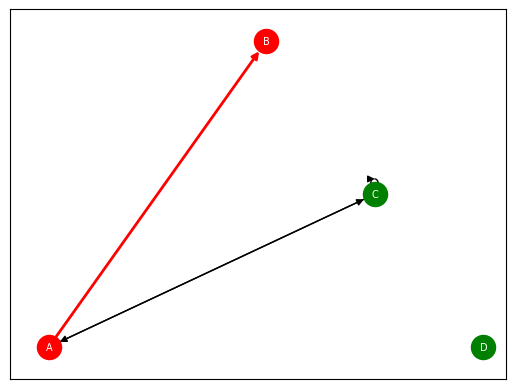

In [ ]:
input_g = _create_graph(
    [('A', {'attr_a': 'a'}),'B','C','D'], 
    [
        ('A','B'),
        ('A','C', {'attr_ac': 'ac'}),
        ('C', 'C'),
        ('A', 'C'),
        ('C', 'A')
    ]
)
_plot_graph(input_g, hl_nodes=['A','B'], hl_edges=[('A','B')], node_attrs=True, edge_attrs=True)